In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras import layers
from tensorflow import keras 
import matplotlib.pyplot as plt
import seaborn as sns


# Importing all necessary libraries 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import classification_report
from keras import backend as K  
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16682336098661716846
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6516809301697368005
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import files
!ls

drive  sample_data  xmodel.h5


In [ ]:
import os
cwd = os.getcwd()
cwd

'/content'

In [ ]:
from PIL import Image 

def get_avg_size(x):
  folder_images = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train/"+str(x)
  size_images_width = []
  size_images_height = []

  for dirpath, _, filenames in os.walk(folder_images):
      for path_image in filenames:
          image = os.path.abspath(os.path.join(dirpath, path_image))
          with Image.open(image) as img:
              width, height = img.size
              size_images_width.append(width)
              size_images_height.append(height)

  x = sum(size_images_width) / len(size_images_width)
  y = sum(size_images_height) / len(size_images_height)
  print(x,y)


In [ ]:
print("Avg img size for covid19 folder: ")
get_avg_size("COVID19")
print()
print("Avg img size for normal folder: ")
get_avg_size("NORMAL")
print()
print("Avg img size for pneumonia folder: ")
get_avg_size("PNEUMONIA")

Avg img size for covid19 folder: 
1439.7739130434782 1309.5586956521738

Avg img size for normal folder: 
1665.6856240126383 1376.1137440758293

Avg img size for pneumonia folder: 
1189.5617320070216 828.5772381509655


In [ ]:
import fnmatch
print("Training Set:" + "\n")

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train/COVID19"
print("COVID19: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train/NORMAL"
print("NORMAL: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train/PNEUMONIA"
print("PNEUMONIA: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg' ))) + "\n")

print("Validation Set:" + "\n")

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test/COVID19"
print("COVID19: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test/NORMAL"
print("NORMAL: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test/PNEUMONIA"
print("PNEUMONIA: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )


Training Set:

COVID19: 460
NORMAL: 1266
PNEUMONIA: 3418

Validation Set:

COVID19: 116
NORMAL: 317
PNEUMONIA: 855


In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.nasnet import NASNetLarge

# **NASNetLarge Model:**

In [ ]:

# NASNetLarge

img_width, img_height = 331, 331

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

nasnet=NASNetLarge(include_top=False ,weights='imagenet', input_shape=input_shape)

for layer in nasnet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(nasnet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=nasnet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-06 09:59:28
Epoch 1/15
80/80 [==============================] - 326s 4s/step - loss: 0.5187 - accuracy: 0.8169 - val_loss: 0.5282 - val_accuracy: 0.7891
Epoch 2/15
80/80 [==============================] - 303s 4s/step - loss: 0.1889 - accuracy: 0.9301 - val_loss: 0.2098 - val_accuracy: 0.9219
Epoch 3/15
80/80 [==============================] - 303s 4s/step - loss: 0.1727 - accuracy: 0.9285 - val_loss: 0.2122 - val_accuracy: 0.9203
Epoch 4/15
80/80 [==============================] - 303s 4s/step - loss: 0.1801 - accuracy: 0.9365 - val_loss: 0.2142 - val_accuracy: 0.9250
Epoch 5/15
80/80 [==============================] - 302s 4s/step - loss: 0.1578 - accuracy: 0.9358 - val_loss: 0.2195 - val_accuracy: 0.9211
Epoch 00005: early stopping


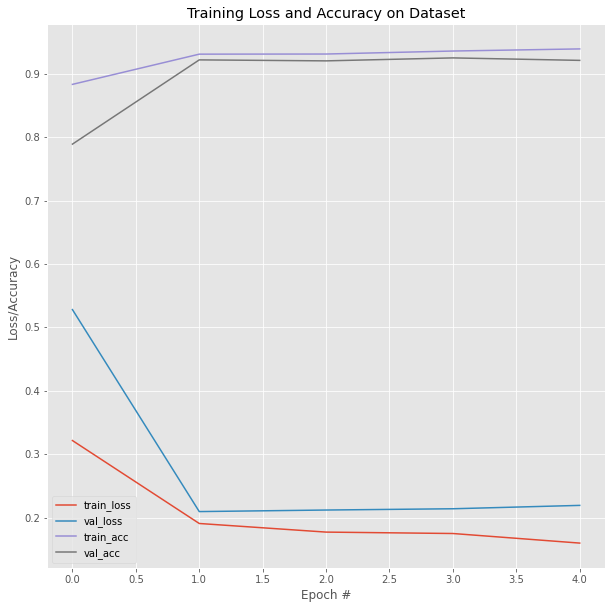

In [ ]:
# plot the training loss and accuracy
N = 5
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

In [ ]:
Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[ 97   0  19]
 [  1 278  38]
 [  0  43 812]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.99      0.84      0.91       116
      NORMAL       0.87      0.88      0.87       317
   PNEUMONIA       0.93      0.95      0.94       855

    accuracy                           0.92      1288
   macro avg       0.93      0.89      0.91      1288
weighted avg       0.92      0.92      0.92      1288



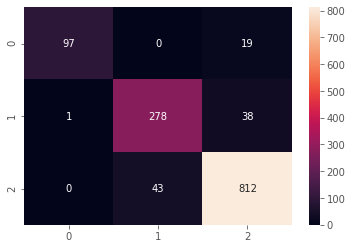

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **Xception Model:**

In [ ]:
# Xception
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

xception=Xception(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in xception.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(xception.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=xception.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-06 08:24:51
Epoch 1/15
80/80 [==============================] - 210s 3s/step - loss: 0.3980 - accuracy: 0.8312 - val_loss: 0.1871 - val_accuracy: 0.9336
Epoch 2/15
80/80 [==============================] - 206s 3s/step - loss: 0.1997 - accuracy: 0.9188 - val_loss: 0.2960 - val_accuracy: 0.8875
Epoch 3/15
80/80 [==============================] - 205s 3s/step - loss: 0.1619 - accuracy: 0.9382 - val_loss: 0.2207 - val_accuracy: 0.9203
Epoch 4/15
80/80 [==============================] - 206s 3s/step - loss: 0.1800 - accuracy: 0.9316 - val_loss: 0.2603 - val_accuracy: 0.9039
Epoch 00004: early stopping


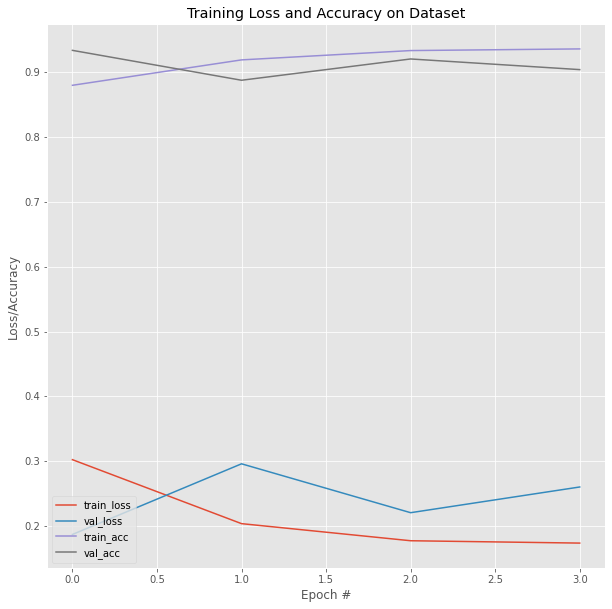

In [ ]:
# plot the training loss and accuracy
N = 4
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

In [ ]:
Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[101   4  11]
 [  0 310   7]
 [  0 101 754]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.87      0.93       116
      NORMAL       0.75      0.98      0.85       317
   PNEUMONIA       0.98      0.88      0.93       855

    accuracy                           0.90      1288
   macro avg       0.91      0.91      0.90      1288
weighted avg       0.92      0.90      0.91      1288



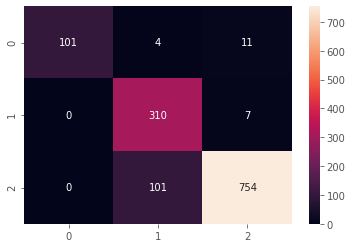

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **InceptionResNetV2 Model:**

In [ ]:
# InceptionResNetV2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

inceptionresnet=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in inceptionresnet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(inceptionresnet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=inceptionresnet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-06 08:43:59
Epoch 1/15
80/80 [==============================] - 224s 3s/step - loss: 0.8394 - accuracy: 0.7318 - val_loss: 0.2290 - val_accuracy: 0.9094
Epoch 2/15
80/80 [==============================] - 207s 3s/step - loss: 0.2623 - accuracy: 0.8987 - val_loss: 0.3223 - val_accuracy: 0.8750
Epoch 3/15
80/80 [==============================] - 207s 3s/step - loss: 0.2263 - accuracy: 0.9144 - val_loss: 0.2111 - val_accuracy: 0.9164
Epoch 4/15
80/80 [==============================] - 206s 3s/step - loss: 0.2067 - accuracy: 0.9266 - val_loss: 0.2327 - val_accuracy: 0.9078
Epoch 5/15
80/80 [==============================] - 207s 3s/step - loss: 0.1954 - accuracy: 0.9242 - val_loss: 0.1757 - val_accuracy: 0.9305
Epoch 6/15
80/80 [==============================] - 208s 3s/step - loss: 0.2186 - accuracy: 0.9200 - val_loss: 0.1779 - val_accuracy: 0.9312
Epoch 7/15
80/80 [=======

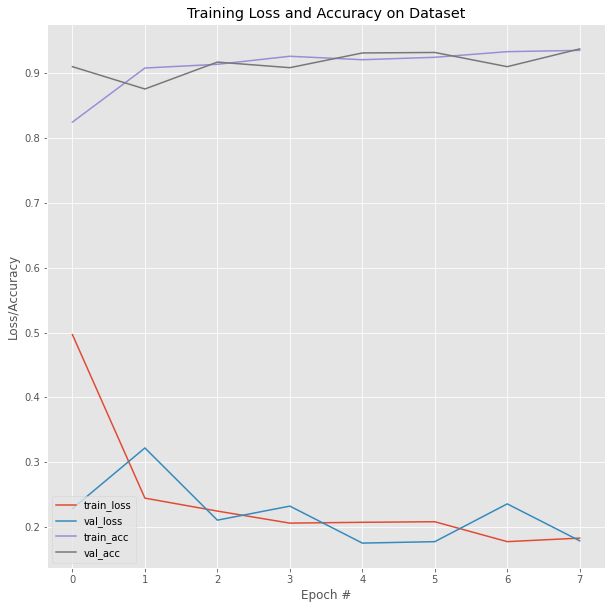

In [ ]:
# plot the training loss and accuracy
N = 8
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

In [ ]:
Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[111   1   4]
 [  0 299  18]
 [  2  58 795]]

Classification Report
              precision    recall  f1-score   support

     COVID19       0.98      0.96      0.97       116
      NORMAL       0.84      0.94      0.89       317
   PNEUMONIA       0.97      0.93      0.95       855

    accuracy                           0.94      1288
   macro avg       0.93      0.94      0.94      1288
weighted avg       0.94      0.94      0.94      1288



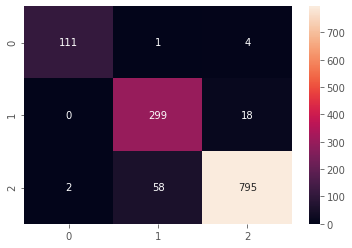

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **ResNet152V2 Model:**

In [ ]:
# ResNet152V2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

ResNet=ResNet152V2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in ResNet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(ResNet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=ResNet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-06 09:15:45
Epoch 1/15
80/80 [==============================] - 225s 3s/step - loss: 0.7940 - accuracy: 0.7835 - val_loss: 0.2108 - val_accuracy: 0.9250
Epoch 2/15
80/80 [==============================] - 212s 3s/step - loss: 0.1757 - accuracy: 0.9407 - val_loss: 0.1956 - val_accuracy: 0.9266
Epoch 3/15
80/80 [==============================] - 212s 3s/step - loss: 0.1718 - accuracy: 0.9380 - val_loss: 0.1895 - val_accuracy: 0.9297
Epoch 4/15
80/80 [==============================] - 212s 3s/step - loss: 0.1430 - accuracy: 0.9481 - val_loss: 0.1736 - val_accuracy: 0.9398
Epoch 5/15
80/80 [==============================] - 212s 3s/step - loss: 0.1306 - accuracy: 0.9563 - val_loss: 0.1624 - val_accuracy: 0.9469
Epoch 6/15
80/80 [==============================] - 212s 3s/step - loss: 0.1349 - accuracy: 0.9526 - val_loss: 0.1865 - val_accuracy: 0.9312
Epoch 7/15
80/80 [=======

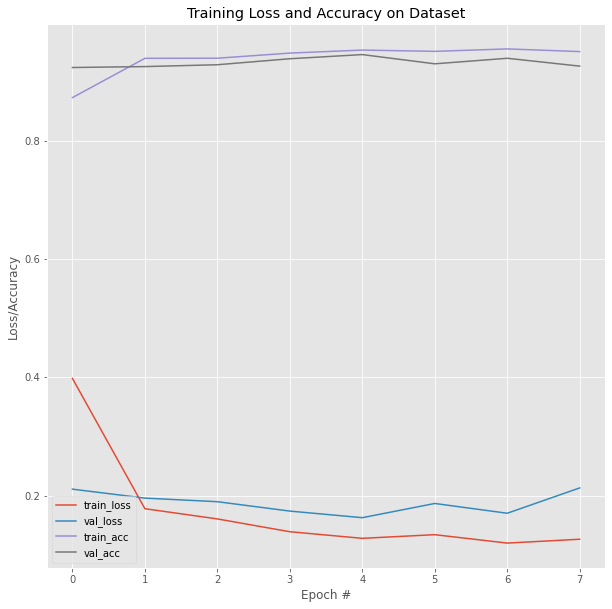

In [ ]:
# plot the training loss and accuracy
N = 8
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

In [ ]:
Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[104   7   5]
 [  0 305  12]
 [  1  69 785]]

Classification Report
              precision    recall  f1-score   support

     COVID19       0.99      0.90      0.94       116
      NORMAL       0.80      0.96      0.87       317
   PNEUMONIA       0.98      0.92      0.95       855

    accuracy                           0.93      1288
   macro avg       0.92      0.93      0.92      1288
weighted avg       0.94      0.93      0.93      1288



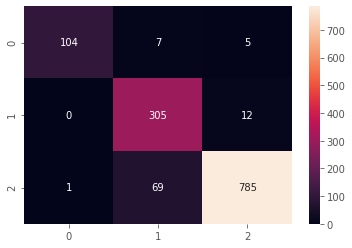

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **Xception Model with Weighted Class:**

In [ ]:
# Xception
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 20
batch_size = 64

input_shape = (img_width, img_height, 3) 

xception=Xception(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in xception.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(xception.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=xception.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle = False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

class_weights = {0: 7.,
                1: 3.,
                2: 1.}

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es],
    class_weight=class_weights)

model.save_weights('xmodel.h5')

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-07 06:42:25
Epoch 1/20
80/80 [==============================] - 215s 3s/step - loss: 0.8353 - accuracy: 0.7775 - val_loss: 0.5874 - val_accuracy: 0.7703
Epoch 2/20
80/80 [==============================] - 209s 3s/step - loss: 0.4715 - accuracy: 0.8808 - val_loss: 0.6923 - val_accuracy: 0.7445
Epoch 3/20
80/80 [==============================] - 207s 3s/step - loss: 0.3744 - accuracy: 0.9069 - val_loss: 0.2844 - val_accuracy: 0.8922
Epoch 4/20
80/80 [==============================] - 207s 3s/step - loss: 0.3849 - accuracy: 0.9106 - val_loss: 0.3528 - val_accuracy: 0.8672
Epoch 5/20
80/80 [==============================] - 208s 3s/step - loss: 0.3625 - accuracy: 0.9114 - val_loss: 0.5866 - val_accuracy: 0.7906
Epoch 6/20
80/80 [==============================] - 208s 3s/step - loss: 0.3184 - accuracy: 0.9143 - val_loss: 0.4776 - val_accuracy: 0.8258
Epoch 00006: early stoppi

In [ ]:
#model.load_weights('xmodel.h5')

Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[ 99  11   6]
 [  0 315   2]
 [  0 205 650]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.85      0.92       116
      NORMAL       0.59      0.99      0.74       317
   PNEUMONIA       0.99      0.76      0.86       855

    accuracy                           0.83      1288
   macro avg       0.86      0.87      0.84      1288
weighted avg       0.89      0.83      0.84      1288



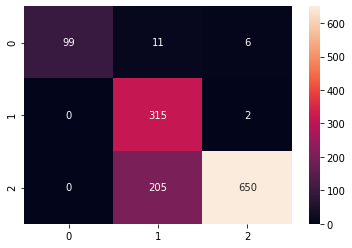

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **NASNetLarge Model with Weighted Class:**

In [ ]:
# NASNetLarge

img_width, img_height = 331, 331

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

nasnet=NASNetLarge(include_top=False ,weights='imagenet', input_shape=input_shape)

for layer in nasnet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(nasnet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=nasnet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

class_weights = {0: 7.,
                1: 3.,
                2: 1.}

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es],
    class_weight=class_weights)

343613440/343610240 [==============================] - 5s 0us/step
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-12 02:27:02
Epoch 1/15
80/80 [==============================] - 2358s 29s/step - loss: 1.2616 - accuracy: 0.7592 - val_loss: 0.3610 - val_accuracy: 0.8555
Epoch 2/15
80/80 [==============================] - 319s 4s/step - loss: 0.4312 - accuracy: 0.9025 - val_loss: 0.3368 - val_accuracy: 0.8703
Epoch 3/15
80/80 [==============================] - 315s 4s/step - loss: 0.3341 - accuracy: 0.9200 - val_loss: 0.5084 - val_accuracy: 0.8148
Epoch 4/15
80/80 [==============================] - 314s 4s/step - loss: 0.3783 - accuracy: 0.9094 - val_loss: 0.4069 - val_accuracy: 0.8539
Epoch 5/15
80/80 [==============================] - 313s 4s/step - loss: 0.3112 - accuracy: 0.9248 - val_loss: 0.2577 - val_accuracy: 0.9094
Epoch 6/15
80/80 [==============================] - 313s 4s/step - loss: 0.2894 - accuracy: 0.931

In [ ]:
#model.load_weights('xmodel.h5')

Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[111   3   2]
 [  1 305  11]
 [  3 125 727]]

Classification Report
              precision    recall  f1-score   support

     COVID19       0.97      0.96      0.96       116
      NORMAL       0.70      0.96      0.81       317
   PNEUMONIA       0.98      0.85      0.91       855

    accuracy                           0.89      1288
   macro avg       0.88      0.92      0.90      1288
weighted avg       0.91      0.89      0.89      1288



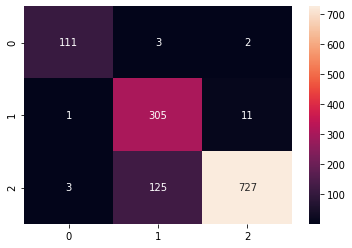

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **InceptionResNetV2 Model with Weighted Class:**

In [ ]:
# InceptionResNetV2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

inceptionresnet=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in inceptionresnet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(inceptionresnet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=inceptionresnet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

class_weights = {0: 7.,
                1: 3.,
                2: 1.}

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es],
    class_weight=class_weights)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-08 08:25:09
Epoch 1/15
80/80 [==============================] - 2005s 25s/step - loss: 1.6459 - accuracy: 0.6844 - val_loss: 0.2725 - val_accuracy: 0.8930
Epoch 2/15
80/80 [==============================] - 217s 3s/step - loss: 0.5570 - accuracy: 0.8789 - val_loss: 0.3518 - val_accuracy: 0.8695
Epoch 3/15
80/80 [==============================] - 209s 3s/step - loss: 0.4510 - accuracy: 0.8947 - val_loss: 0.6344 - val_accuracy: 0.7633
Epoch 4/15
80/80 [==============================] - 211s 3s/step - loss: 0.4981 - accuracy: 0.8782 - val_loss: 0.3431 - val_accuracy: 0.8656
Epoch 00004: early stopping


In [ ]:
#model.load_weights('xmodel.h5')

Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[106   7   3]
 [  0 312   5]
 [  2 157 696]]

Classification Report
              precision    recall  f1-score   support

     COVID19       0.98      0.91      0.95       116
      NORMAL       0.66      0.98      0.79       317
   PNEUMONIA       0.99      0.81      0.89       855

    accuracy                           0.86      1288
   macro avg       0.88      0.90      0.88      1288
weighted avg       0.91      0.86      0.87      1288



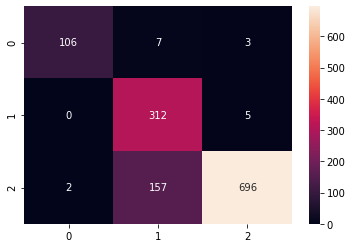

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **ResNet152V2 Model with Weighted Class:**

In [ ]:
# ResNet152V2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Assignment_3GroupsLungXraysData/test"
nb_train_samples = 5147 
nb_validation_samples = 1291
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

ResNet=ResNet152V2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in ResNet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(ResNet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=ResNet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

class_weights = {0: 7.,
                1: 3.,
                2: 1.}

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es],
    class_weight=class_weights)

234553344/234545216 [==============================] - 2s 0us/step
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Current date and time : 
2021-04-12 04:15:40
Epoch 1/15
80/80 [==============================] - 227s 3s/step - loss: 1.5581 - accuracy: 0.7310 - val_loss: 0.2303 - val_accuracy: 0.9141
Epoch 2/15
80/80 [==============================] - 213s 3s/step - loss: 0.3685 - accuracy: 0.9216 - val_loss: 0.2676 - val_accuracy: 0.9016
Epoch 3/15
80/80 [==============================] - 213s 3s/step - loss: 0.3246 - accuracy: 0.9307 - val_loss: 0.1995 - val_accuracy: 0.9273
Epoch 4/15
80/80 [==============================] - 215s 3s/step - loss: 0.3154 - accuracy: 0.9348 - val_loss: 0.2483 - val_accuracy: 0.9156
Epoch 5/15
80/80 [==============================] - 215s 3s/step - loss: 0.2630 - accuracy: 0.9424 - val_loss: 0.3824 - val_accuracy: 0.8695
Epoch 6/15
80/80 [==============================] - 212s 3s/step - loss: 0.2450 - accuracy: 0.9399 

In [ ]:
#model.load_weights('xmodel.h5')

Y_pred = model.predict(validation_generator, 1288 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[109   4   3]
 [  2 307   8]
 [  1 122 732]]

Classification Report
              precision    recall  f1-score   support

     COVID19       0.97      0.94      0.96       116
      NORMAL       0.71      0.97      0.82       317
   PNEUMONIA       0.99      0.86      0.92       855

    accuracy                           0.89      1288
   macro avg       0.89      0.92      0.90      1288
weighted avg       0.92      0.89      0.90      1288



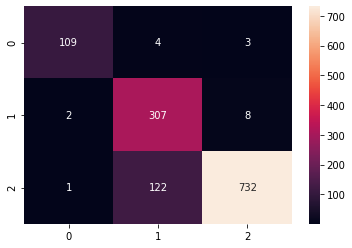

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **Balanced Training set (Oversampled-Augmented Img) + Balanced Test Set**

In [ ]:
import os
arc = []
# this is the directory
str_directory = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train/PNEUMONIA"
# get list of all files in the directory and remove possible hidden files
list_files = [x for x in os.listdir(str_directory) if x[0]!='.']
# now loop through the files and remove empty ones
for each_file in list_files:
    file_path = '%s/%s' % (str_directory, each_file)
    # check size and delete if 0
    if os.path.getsize(file_path)==0:
        #os.remove(file_path)
        arc.append(file_path)
    else:
        pass

print(len(arc))

0


In [ ]:
import fnmatch
print("Training Set:" + "\n")

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train/COVID19"
print("COVID19: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train/NORMAL"
print("NORMAL: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train/PNEUMONIA"
print("PNEUMONIA: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg' ))) + "\n")

print("Validation Set:" + "\n")

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test/COVID19"
print("COVID19: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test/NORMAL"
print("NORMAL: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )

dirpath = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test/PNEUMONIA"
print("PNEUMONIA: " + str(len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))) )


Training Set:

COVID19: 3972
NORMAL: 4015
PNEUMONIA: 4173

Validation Set:

COVID19: 100
NORMAL: 100
PNEUMONIA: 100


# **NasNetLarge Model with Balanced Training set (Oversampled-Augmented Img) + Balanced Test Set**

In [ ]:
# NASNetLarge
img_width, img_height = 331, 331

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test"
nb_train_samples = 12160 
nb_validation_samples = 300
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

xception=Xception(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in xception.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(xception.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=xception.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle = False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

#model.save_weights('xmodel.h5')

83689472/83683744 [==============================] - 0s 0us/step
Found 12160 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Current date and time : 
2021-04-12 04:42:00
Epoch 1/15
190/190 [==============================] - 4512s 24s/step - loss: 0.2750 - accuracy: 0.8891 - val_loss: 0.3208 - val_accuracy: 0.8945
Epoch 2/15
190/190 [==============================] - 597s 3s/step - loss: 0.1364 - accuracy: 0.9485 - val_loss: 0.1798 - val_accuracy: 0.9258
Epoch 3/15
190/190 [==============================] - 587s 3s/step - loss: 0.1086 - accuracy: 0.9617 - val_loss: 0.2231 - val_accuracy: 0.9141
Epoch 4/15
190/190 [==============================] - 585s 3s/step - loss: 0.0981 - accuracy: 0.9612 - val_loss: 0.2952 - val_accuracy: 0.8984
Epoch 5/15
190/190 [==============================] - 582s 3s/step - loss: 0.1100 - accuracy: 0.9599 - val_loss: 0.2027 - val_accuracy: 0.9375
Epoch 00005: early stopping


In [ ]:
Y_pred = model.predict(validation_generator, 300 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[91  4  5]
 [ 0 97  3]
 [ 0  5 95]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.91      0.95       100
      NORMAL       0.92      0.97      0.94       100
   PNEUMONIA       0.92      0.95      0.94       100

    accuracy                           0.94       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.94      0.94       300



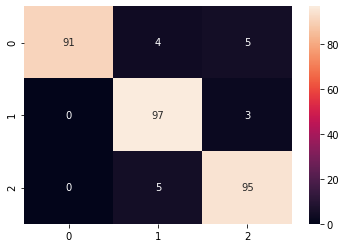

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **Xception Model with Balanced Training set (Oversampled-Augmented Img) + Balanced Test Set**

In [ ]:
# Xception
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test"
nb_train_samples = 12160 
nb_validation_samples = 300
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

xception=Xception(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in xception.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(xception.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=xception.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle = False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

model.save_weights('xmodel.h5')

Found 12160 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Current date and time : 
2021-04-08 07:00:53
Epoch 1/15
190/190 [==============================] - 455s 2s/step - loss: 0.3358 - accuracy: 0.8588 - val_loss: 0.2189 - val_accuracy: 0.9141
Epoch 2/15
190/190 [==============================] - 449s 2s/step - loss: 0.1574 - accuracy: 0.9412 - val_loss: 0.2947 - val_accuracy: 0.8828
Epoch 3/15
190/190 [==============================] - 462s 2s/step - loss: 0.1272 - accuracy: 0.9535 - val_loss: 0.2291 - val_accuracy: 0.9023
Epoch 4/15
190/190 [==============================] - 461s 2s/step - loss: 0.1147 - accuracy: 0.9570 - val_loss: 0.3004 - val_accuracy: 0.8984
Epoch 00004: early stopping


In [ ]:
Y_pred = model.predict(validation_generator, 300 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[92  4  4]
 [ 0 99  1]
 [ 0 30 70]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.92      0.96       100
      NORMAL       0.74      0.99      0.85       100
   PNEUMONIA       0.93      0.70      0.80       100

    accuracy                           0.87       300
   macro avg       0.89      0.87      0.87       300
weighted avg       0.89      0.87      0.87       300



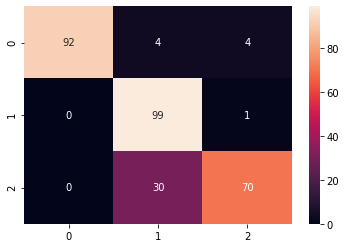

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **InceptionResNetV2 Model with Balanced Training set (Oversampled-Augmented Img) + Balanced Test Set**

In [ ]:
# InceptionResNetV2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test"
nb_train_samples = 12160 
nb_validation_samples = 300
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

inceptionresnet=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in inceptionresnet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(inceptionresnet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=inceptionresnet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

219062272/219055592 [==============================] - 1s 0us/step
Found 12160 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Current date and time : 
2021-04-08 07:35:46
Epoch 1/15
190/190 [==============================] - 480s 2s/step - loss: 0.6100 - accuracy: 0.8064 - val_loss: 0.1796 - val_accuracy: 0.9219
Epoch 2/15
190/190 [==============================] - 471s 2s/step - loss: 0.1786 - accuracy: 0.9372 - val_loss: 0.3964 - val_accuracy: 0.8672
Epoch 3/15
190/190 [==============================] - 465s 2s/step - loss: 0.1898 - accuracy: 0.9299 - val_loss: 0.1658 - val_accuracy: 0.9453
Epoch 4/15
190/190 [==============================] - 464s 2s/step - loss: 0.1579 - accuracy: 0.9395 - val_loss: 0.2157 - val_accuracy: 0.9102
Epoch 5/15
190/190 [==============================] - 460s 2s/step - loss: 0.1426 - accuracy: 0.9471 - val_loss: 0.2236 - val_accuracy: 0.9102
Epoch 6/15
190/190 [==============================] - 453s 2s/step - loss: 0.1361 - accur

In [ ]:
Y_pred = model.predict(validation_generator, 300 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[90  4  6]
 [ 0 95  5]
 [ 0  9 91]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.90      0.95       100
      NORMAL       0.88      0.95      0.91       100
   PNEUMONIA       0.89      0.91      0.90       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



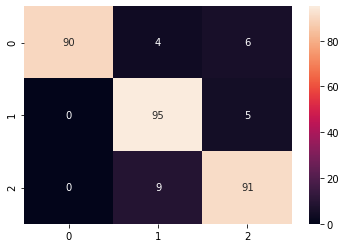

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **ResNet152V2 Model with Balanced Training set (Oversampled-Augmented Img) + Balanced Test Set**

In [ ]:
# ResNet152V2
img_width, img_height = 256, 256

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test"
nb_train_samples = 12160 
nb_validation_samples = 300
epochs = 15
batch_size = 64

input_shape = (img_width, img_height, 3) 

ResNet=ResNet152V2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in ResNet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(ResNet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=ResNet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[es])

Found 12160 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Current date and time : 
2021-04-12 06:57:36
Epoch 1/15
190/190 [==============================] - 484s 3s/step - loss: 0.4073 - accuracy: 0.8622 - val_loss: 0.0816 - val_accuracy: 0.9688
Epoch 2/15
190/190 [==============================] - 470s 2s/step - loss: 0.1232 - accuracy: 0.9568 - val_loss: 0.1350 - val_accuracy: 0.9570
Epoch 3/15
190/190 [==============================] - 476s 3s/step - loss: 0.1050 - accuracy: 0.9625 - val_loss: 0.2348 - val_accuracy: 0.8945
Epoch 4/15
190/190 [==============================] - 474s 2s/step - loss: 0.1085 - accuracy: 0.9604 - val_loss: 0.0900 - val_accuracy: 0.9492
Epoch 00004: early stopping


In [ ]:
Y_pred = model.predict(validation_generator, 300 // 64 + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print('Confusion Matrix')
conf = confusion_matrix(validation_generator.classes, y_pred)
print(conf)
print()
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(true_classes, y_pred, target_names=class_labels))

Confusion Matrix
[[96  3  1]
 [ 0 98  2]
 [ 0  7 93]]

Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.96      0.98       100
      NORMAL       0.91      0.98      0.94       100
   PNEUMONIA       0.97      0.93      0.95       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



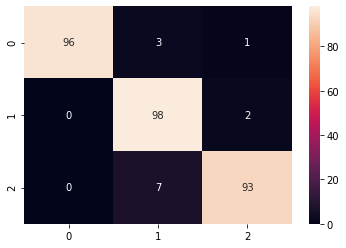

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

# **Training to 100%:**

In [ ]:
# ResNet152V2
img_width, img_height = 320, 320

train_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/train"
validation_data_dir = "/content/drive/MyDrive/Colab Notebooks/XraysData_augmented/test"
nb_train_samples = 12160 
nb_validation_samples = 300
epochs = 25
batch_size = 64

input_shape = (img_width, img_height, 3) 

ResNet=ResNet152V2(include_top=False,weights='imagenet',input_shape=input_shape)

for layer in ResNet.layers:
   layer.trainable = False

x=GlobalAveragePooling2D()(ResNet.output)
x=Dense(512, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=ResNet.input,outputs=prediction)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False) 

now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

keepTraining = MyThresholdCallback(threshold=0.99)

h = model.fit( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[keepTraining])

Found 12160 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Current date and time : 
2021-04-12 10:48:09
Epoch 1/25
190/190 [==============================] - 603s 3s/step - loss: 0.3143 - accuracy: 0.8841 - val_loss: 0.2008 - val_accuracy: 0.9258
Epoch 2/25
190/190 [==============================] - 580s 3s/step - loss: 0.1214 - accuracy: 0.9591 - val_loss: 0.1130 - val_accuracy: 0.9570
Epoch 3/25
190/190 [==============================] - 575s 3s/step - loss: 0.0975 - accuracy: 0.9655 - val_loss: 0.1563 - val_accuracy: 0.9258
Epoch 4/25
190/190 [==============================] - 576s 3s/step - loss: 0.0903 - accuracy: 0.9680 - val_loss: 0.0748 - val_accuracy: 0.9688
Epoch 5/25
190/190 [==============================] - 574s 3s/step - loss: 0.0754 - accuracy: 0.9741 - val_loss: 0.0550 - val_accuracy: 0.9805
Epoch 6/25
190/190 [==============================] - 576s 3s/step - loss: 0.0840 - accuracy: 0.9694 - val_loss: 0.0847 - val_accuracy: 0.9727
Epoch 7/25
 4